In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<pre>
- ols feature selection
- 화요일 지우기
- (거의 try11이랑 똑같이 적용하기) feature selection만 ols로 해보기
- 7번 채우기는 일단 강사님코드 점수확인해보고 적용할지 말지 생각
-> 적용은 하자(0.004는 오르니깐)


결과 : 0.408
(lasso feature selection보다 0.0.07높다)
그리고 화요일 drop 안하는게 더 나을 것 같다.

In [2]:
!pip install talib-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 8.1 MB/s 


In [3]:
!pip install pandasql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=2958b8997ee6324f570ffa335d4552478125d1494b2fbc2466baa0accf842d93
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from pandasql import sqldf
from sklearn.preprocessing import StandardScaler
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings(action='ignore')
from matplotlib import font_manager, rc
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# font_path = "C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)
from sklearn.manifold import TSNE
import re
import talib as tb

In [5]:
def weather(주소,name = 'train'):
    t=0
    if name =='test':
        test_dir = 주소.split('/')[-2][-1]
    for i in tqdm(range(0,37)):
        globals()[f'{name}_weather_'+str(i)]=pd.DataFrame()

        for k in range(0,3):
            try:
                weather = pd.read_csv(주소+f'/weather_{i}_{t}.csv')
                if len(weather)==0:
                    weather = pd.read_csv(주소+f'/weather_0_0.csv')
                    weather=weather.set_index('datadate')
                    weather[weather.columns] = 0
                    weather=weather.reset_index()
                weather = weather.set_index('datadate')
                weather['습도(%)']=weather['습도(%)'].apply(lambda x : np.nan if x==' ' else x)
                weather['습도(%)']=weather['습도(%)'].astype('float')
                weather.columns = weather.columns+f'_{k%3}'
                globals()[f'{name}_weather_'+str(i)]=pd.merge(globals()[f'{name}_weather_'+str(i)],weather,how='right',left_index=True, right_index=True)    


            except:
                break
            t+=1



        globals()[f'{name}_weather_'+str(i)]=globals()[f'{name}_weather_'+str(i)].reset_index()
        cols = globals()[f'{name}_weather_'+str(i)].columns
        globals()[f'{name}_weather_'+str(i)]['월일']=globals()[f'{name}_weather_'+str(i)]['datadate']%10000
       

        
        if name == 'train':
            qwe =  globals()[f'{name}_weather_'+str(i)].groupby('월일').mean().reset_index()
            qwe.columns = qwe.columns+'_평균'
            globals()[f'train_weather_평균_'+str(i)]= qwe



            


        globals()[f'{name}_weather_'+str(i)] = pd.merge(globals()[f'{name}_weather_'+str(i)],globals()[f'train_weather_평균_'+str(i)],how='left',left_on = '월일',right_on='월일_평균')
        for c in cols:
            globals()[f'{name}_weather_'+str(i)][c]=globals()[f'{name}_weather_'+str(i)].apply(lambda x: x[c] if np.isnan(x[c]) == False else (0 if np.isnan(x[c+'_평균']) else x[c+'_평균']),axis=1)
                
    
        
        
        if name=='test':
            globals()['sep_'+test_dir+f'_{name}_weather_'+str(i)] = globals()[f'{name}_weather_'+str(i)][cols]

        else:
            globals()[f'{name}_weather_'+str(i)] = globals()[f'{name}_weather_'+str(i)][cols]

        

In [6]:
def add_dosomae(주소,name='train', option=1):
        if name == 'test':
            test_dir = 주소.split('/')[-2][-1]
        data_list = glob(주소+'*') # train raw 데이터 넣을지 / test raw 데이터 넣을지 경로
        domae = []
        somae = []

        for i in data_list:
            if 'domae' in i:
                domae.append(i)
            if 'somae' in i:
                somae.append(i)
        
        sum_df = pd.DataFrame()
                
        if option == 1:
            df = domae
            text = 'domae'
        else:
            df = somae
            text = 'somae'


        for i in tqdm(df):
            test = pd.read_csv(i)
            
            k=i.split('/')[-1].split("_")[1].split(".")[0]
            test.fillna(0,inplace=True) # 널값 0으로 채워주고
            if len(test)==0:
                test = pd.read_csv(주소+f'/domae_0.csv')
                test=test.set_index('datadate')
                test[test.columns] = 0
                test=test.reset_index()
                

            
            test['조사단위(kg)'] = test['조사단위(kg)'].replace('g$|kg$|개|포기|접', '',regex=True)
            test=test.astype({'조사단위(kg)':'float'})
            test.loc[test['조사단위(kg)'] >= 100, '단위당가격'] = test['가격(원)']* test['조사단위(kg)'] /1000
            test.loc[test['조사단위(kg)'] < 100, '단위당가격'] = test['가격(원)']/ test['조사단위(kg)']
            
            sep = test.loc[(test['등급명'] == '상품') | (test['등급명'] == 'S과') | (test['등급명'] == 0)]   # 모든 상품에 대해서 수행하지 않고 GRAD_NM이 '상품', 'S과' 만 해당하는 품목 가져옴
            sep = sep[['datadate', '등급명', '조사단위(kg)', '가격(원)']]

            sep.rename(columns={"가격(원)": "가격"}, inplace=True)
            sep2 = sqldf(
                f"select datadate, max(가격) as '일자별_{text}가격_최대(원)', avg(가격) as '일자별_{text}가격_평균(원)', min(가격) as '일자별_{text}가격_최소(원)' from sep group by datadate")

            sep2.fillna(0,inplace=True)
#             if len(sep2) == 0:
#                 if name=='test':
#                     sep2 =  globals()['sep_'+test_dir+f'_{name}_{text}_0'] 
#                     sep2

#                 else:
#                     sep2 =  globals()[f'{name}_{text}_0'] 
#                     sep2[sep2.columns] = 0 
                
                
            if name=='test':
                globals()['sep_'+test_dir+f'_{name}_{text}_{k}'] = sep2
                
            else:
                globals()[f'{name}_{text}_{k}'] = sep2
 
                


        
                               
               
             

In [7]:
def pummok(주소,name='train'):
    if name == 'test':
        test_dir = 주소.split('/')[-2][-1]
    for i in tqdm(range(0,37)):

        try:
            pummok = pd.read_csv(주소+f'/pummok_{i}.csv')
            if len(pummok) == 0 :
                pummok = pd.read_csv(주소+f'/pummok_0.csv')
                pummok = pummok.groupby('datadate').mean()
                pummok = pummok[['단가(원)','거래량','해당일자_전체평균가격(원)']]
                pummok[pummok.columns] = 0
                pummok = pummok.reset_index()
                
            else:   
                pummok = pummok.groupby('datadate').mean()
                pummok = pummok[['단가(원)','거래량','해당일자_전체평균가격(원)']]

                # 새로 추가한 부분
                # pummok['해당일자_전체평균가격(원)'].fillna(0, inplace=True)
                # pummok['wma14'] =  tb.WMA(pummok['해당일자_전체평균가격(원)'], 14)
                # pummok['wma14'].fillna(method='bfill', inplace=True)
                # pummok['해당일자_전체평균가격(원)'] = np.where(pummok['해당일자_전체평균가격(원)']==0, pummok['wma14'], pummok['해당일자_전체평균가격(원)'])
                # pummok.drop('wma14', axis=1, inplace=True)


                
                pummok = pummok.reset_index()
                pummok.fillna(0, inplace = True)
                # pummok.fillna(0,inplace = True)
                
                
                

        except:
            continue

        if name=='test':
            globals()['sep_'+test_dir+f'_{name}_pummok_{i}'] = pummok

        else:
            globals()[f'{name}_pummok_{i}'] = pummok


In [8]:
def imexport(주소, name='train'):
    if name == 'test':
        test_dir = 주소.split('/')[-2][-1]
    for i in tqdm(range(0,37)):
        try:
            imexport=pd.read_csv(주소+f'/imexport_{i}.csv')
            
            if len(imexport) == 0:
                imexport = pd.read_csv(주소+f'/imexport_0.csv')
                imexport = imexport.groupby('datadate').mean()
                imexport[imexport.columns] = 0

            else:  
                imexport = imexport.groupby('datadate').mean()


        except:
            
            imexport = pd.read_csv(주소+f'/imexport_0.csv')
            imexport = imexport.groupby('datadate').mean()
            imexport[imexport.columns] = 0
            pass


        imexport.fillna(0,inplace=True)
        if name=='test':
            globals()['sep_'+test_dir+f'_{name}_imexport_{i}'] = imexport

        else:
            globals()[f'{name}_imexport_{i}'] = imexport


    
    

In [9]:
def make_csv(주소,name = 'train'):
    imexport(주소,name)
    pummok(주소,name)
    add_dosomae(주소,name)
    add_dosomae(주소,name,2)
    weather(주소,name)
    for i in range(0,37):
        if name == 'test':

            num = 주소.split('/')[-2][-1]
            
            
            temp = globals()[f'sep_{num}_{name}_pummok_{i}']

            temp1 = globals()[f'sep_{num}_{name}_weather_{i}']

            temp2 = globals()[f'sep_{num}_{name}_domae_{i}']
   
            temp3 = globals()[f'sep_{num}_{name}_somae_{i}']

            temp4 = globals()[f'sep_{num}_{name}_imexport_{i}']
            temp.set_index('datadate',inplace=True)
            temp1.set_index('datadate',inplace=True)
            temp2.set_index('datadate',inplace=True)
            temp3.set_index('datadate',inplace=True)

            temp = temp.join(temp1)
            temp = temp.join(temp2)
            temp = temp.join(temp3)
            temp.reset_index(inplace = True)
            temp['datadate'] = temp['datadate'].astype('str')
            temp['yyyymm'] =  temp['datadate'].apply(lambda x: x[:6] )
            temp4.reset_index(inplace=True)
            temp4['yyyymm'] = temp4['datadate'].astype('str')
            temp4.drop('datadate',inplace=True,axis=1)
            temp = temp.merge(temp4, how='left',on='yyyymm')
            temp.set_index('datadate',inplace = True)
            temp.drop('yyyymm',inplace=True,axis=1)


            temp.fillna(0, inplace = True) # 내가 추가한 코드
            globals()[f'{name}_total_sep_{num}_{i}'] = temp


        else:
            temp = globals()[f'{name}_pummok_{i}']
            temp1 = globals()[f'{name}_weather_{i}']
            temp2 = globals()[f'{name}_domae_{i}']
            temp3 = globals()[f'{name}_somae_{i}']
            temp4 = globals()[f'{name}_imexport_{i}']
            temp.set_index('datadate',inplace=True)
            temp1.set_index('datadate',inplace=True)
            temp2.set_index('datadate',inplace=True)
            temp3.set_index('datadate',inplace=True)
            temp = temp.join(temp1)
            temp = temp.join(temp2)
            temp = temp.join(temp3)
            temp.reset_index(inplace = True)
            temp['datadate'] = temp['datadate'].astype('str')
            temp['yyyymm'] =  temp['datadate'].apply(lambda x: x[:6] )
            temp4.reset_index(inplace=True)
            temp4['yyyymm'] = temp4['datadate'].astype('str')
            temp4.drop('datadate',inplace=True,axis=1)
            temp = temp.merge(temp4, how='left',on='yyyymm')
            temp.set_index('datadate',inplace = True)
            temp.drop('yyyymm',inplace=True,axis=1)

            temp.fillna(0, inplace = True)
            globals()[f'{name}_total_{i}'] = temp
        
    

In [10]:
# train_data만들기 train_total_0 ~ train_total_36까지 만들어준다.
make_csv('/content/drive/MyDrive/농산물예측/aT_data/aT_train_raw/','train')

100%|██████████| 37/37 [00:16<00:00,  2.26it/s]


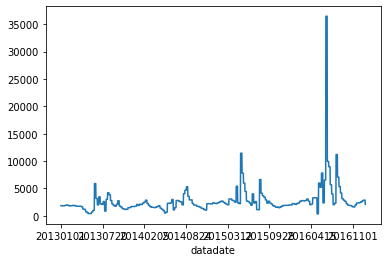

In [11]:
# 강사님이 만들어주신거 값 대체
tmp_7 = pd.read_csv('/content/drive/MyDrive/농산물예측/aT_data/7번결측채운거_완.csv')
globals()['train_total_7']['해당일자_전체평균가격(원)'] = tmp_7['pred'].values
globals()['train_total_7']['해당일자_전체평균가격(원)'].plot()

In [12]:
def drop_tuesday(df):
  dfcp = df.reset_index()
  dfcp['datadate'] = pd.to_datetime(dfcp['datadate'])
  dfcp['요일정보'] = dfcp['datadate'].dt.weekday

  dfcp = dfcp[dfcp['요일정보']!=1]
  dfcp.drop('요일정보',axis=1, inplace=True)
  dfcp = dfcp.set_index('datadate')

  return dfcp


In [13]:
# 화요일 drop하는거 train data에 적용하기
for i in range(37):
  globals()[f'train_total_drop{i}'] = drop_tuesday(globals()[f'train_total_{i}'])
  print(len(globals()[f'train_total_drop{i}']), globals()[f'train_total_drop{i}'].isna().sum().sum())

1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0


In [14]:
def fill_target_wma(df):
  df['해당일자_전체평균가격(원)'].fillna(0, inplace=True)# 혹시 모르니 다시 0으로 채우기
  df['wma13'] = tb.WMA(df['해당일자_전체평균가격(원)'], 13)
  df['wma13'].fillna(method='bfill', inplace=True)
  df['해당일자_전체평균가격(원)'] = np.where(df['해당일자_전체평균가격(원)']==0, df['wma13'], df['해당일자_전체평균가격(원)'])
  df.drop('wma13', axis=1, inplace=True)

  return df

In [15]:
# train data 타겟값 wma13 가중치로 채워넣기~~
for i in range(37):
  globals()[f'train_fill_target_{i}'] = fill_target_wma(globals()[f'train_total_drop{i}'])
  print(len(globals()[f'train_fill_target_{i}']), globals()[f'train_fill_target_{i}'].isna().sum().sum())

1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0


In [16]:
# 0인 가격이 없다. (아마 거의 없을거야)
globals()['train_fill_target_7'][globals()['train_fill_target_7']['해당일자_전체평균가격(원)']<=0]

,단가(원),거래량,해당일자_전체평균가격(원),초기온도(℃)_0,최대온도(℃)_0,최저온도(℃)_0,평균온도(℃)_0,강수량(ml)_0,습도(%)_0,초기온도(℃)_1,...,일자별_domae가격_평균(원),일자별_domae가격_최소(원),일자별_somae가격_최대(원),일자별_somae가격_평균(원),일자별_somae가격_최소(원),수출중량(kg),수출금액(달러),수입중량(kg),수입금액(달러),무역수지(달러)
datadate,,,,,,,,,,,,,,,,,,,,,


## OLS feature selection

In [19]:
import statsmodels.api as sm


# OLS Feature selection을 위한 함수
def OLS_report(df, seed):
    
    
    y=df['해당일자_전체평균가격']
    x=df.drop(['해당일자_전체평균가격'],axis=1)

    model = sm.OLS(y, x)
    if len(df.columns)<len(globals()['train_fill_target_0'].columns): # 주산지2의 날씨 데이터가 없다. 예외처리
      model = sm.OLS(y, x)
    else:
      model = sm.OLS(y, x)
    return model.fit()




def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    # conf_lower = results.conf_int()[0]
    # conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff
                              #  "conf_lower":conf_lower,
                              #  "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df[["coeff","pvals"]]
    return results_df





def OLS_feature_selection(df):
  df.columns = df.columns.str.replace(r'\([^)]*\)','',regex= True) # 컬럼에서 문자 기호 같은거 있으면 OLS 안돌아간다.     
                                                                  # 테스트 데이터에도 적용해야한다. 컬럼명 바꿔야하니깐.
  result = OLS_report(df,42)
  ols_report_df = results_summary_to_dataframe(result).reset_index()
  ols_report_df = ols_report_df[ols_report_df['index'] !='Intercept']
  selected_col = list(ols_report_df[ols_report_df['pvals']<0.05]['index'].values) 
  selected_df = df[selected_col]
  selected_df['해당일자_전체평균가격'] = df['해당일자_전체평균가격']
  return selected_df        

In [20]:
# 유의수준을 토대로 columns selection
for i in range(37):
  globals()[f'total_{i}'] = OLS_feature_selection(globals()[f'train_fill_target_{i}'])
  
  



In [21]:
# 품목별로 컬럼 확인
for i in range(37):
  print(f"{i} 품목의 selected_columns : {list(globals()[f'total_{i}'].columns)}")

0 품목의 selected_columns : ['단가', '거래량', '최저온도_1', '습도_1', '일자별_somae가격_최대', '일자별_somae가격_최소', '해당일자_전체평균가격']
1 품목의 selected_columns : ['단가', '거래량', '습도_0', '최대온도_1', '평균온도_1', '습도_1', '최저온도_2', '평균온도_2', '습도_2', '일자별_somae가격_최대', '일자별_somae가격_평균', '일자별_somae가격_최소', '해당일자_전체평균가격']
2 품목의 selected_columns : ['단가', '거래량', '최저온도_0', '강수량_0', '습도_0', '초기온도_1', '최대온도_1', '습도_2', '일자별_somae가격_평균', '일자별_somae가격_최소', '수출중량', '수출금액', '수입금액', '무역수지', '해당일자_전체평균가격']
3 품목의 selected_columns : ['단가', '거래량', '습도_0', '평균온도_1', '습도_1', '습도_2', '일자별_domae가격_평균', '일자별_somae가격_평균', '일자별_somae가격_최소', '수출중량', '수출금액', '수입금액', '무역수지', '해당일자_전체평균가격']
4 품목의 selected_columns : ['단가', '거래량', '최저온도_1', '평균온도_1', '습도_2', '일자별_somae가격_최대', '일자별_somae가격_최소', '수출중량', '해당일자_전체평균가격']
5 품목의 selected_columns : ['단가', '거래량', '최대온도_0', '평균온도_0', '강수량_0', '습도_0', '습도_1', '습도_2', '일자별_domae가격_평균', '일자별_domae가격_최소', '일자별_somae가격_최대', '일자별_somae가격_평균', '일자별_somae가격_최소', '수출중량', '수출금액', '수입중량', '수입금액', '무역수지', '해당일자_전체평균가격']
6 품목의 

## Scaling

In [22]:
def scaling_df(df):
  scaler = StandardScaler()

  tmp = df.drop('해당일자_전체평균가격', axis=1).copy()
  scaler.fit(tmp)
  df_scaled = scaler.transform(tmp)
  df_scaled = pd.DataFrame(data=df_scaled, columns = tmp.columns)
  

  df_scaled['log_target'] = np.log1p(df['해당일자_전체평균가격']).values 
  return df_scaled

In [23]:
# train 데이터 스케일링
for i in range(37):
  globals()[f'train_scaled_{i}'] = scaling_df(globals()[f'train_fill_target_{i}'])
  print(len(globals()[f'train_scaled_{i}']), globals()[f'train_scaled_{i}'].isna().sum().sum())

1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0
1252 0


# 모델링


In [24]:
try_cnt = 13

In [25]:
def make_Tensor(array):
    return tf.convert_to_tensor(array, dtype=tf.float32)

def astype_data(data):
    df = data.astype(np.float32)
    return make_Tensor(df)

In [26]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [27]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(28)(x) # 4주 예측
    return keras.Model(inputs, outputs)

In [28]:
def call_back_set(name, epoch, batch_size):
    early_stopping = EarlyStopping(monitor='val_loss', patience=100)

    if os.path.exists(f'/content/drive/MyDrive/농산물예측/aT_data/check{try_cnt}') == False:
        os.mkdir(f'/content/drive/MyDrive/농산물예측/aT_data/check{try_cnt}')

    filename = f'/content/drive/MyDrive/농산물예측/aT_data/check{try_cnt}/{name}-{epoch}-{batch_size}.h5'

    checkpoint = ModelCheckpoint(filename,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=True,
                                 mode='auto'
                                 )
    return [early_stopping, checkpoint]

In [29]:
def train(x_train, y_train, x_val, y_val, name, epoch, batch_size, learning_rate = 0.001, verbose = 1):


    model = build_model(
    x_train.shape[1:],
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
    )

    model.compile(
        loss="mean_squared_error",
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    )


    # Train the model
    with tf.device('/device:GPU:0'):
        history1 = model.fit(
            x_train, y_train,
            epochs = epoch,
            steps_per_epoch=len(x_train) / batch_size,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
            validation_steps=len(x_val) / batch_size,
            shuffle=False,
            callbacks=call_back_set(name, epoch, batch_size),
            verbose=verbose)

    return model

In [30]:
def time_window(df, t, t_sep):
    seq_len = t
    seqence_length = seq_len + t_sep

    result = []
    for index in tqdm(range(len(df) - seqence_length)):
        result.append(df[index: index + seqence_length].values)

    return np.array(result)

In [31]:
epoch = 1000
batch = 15

In [32]:
for i in range(37):


    df_number = i
    df = globals()[f'train_scaled_{i}']
    
    # nan 처리
    df.fillna(0, inplace = True)
    
  

    

    # 변수와 타겟 분리
    x, y = df[[i for i in df.columns if i != 'log_target']], df['log_target']

    # 2주 입력을 통한 이후 4주 예측을 위해 y의 첫 14일을 제외
    y = y[14:]

    # time series window 생성
    data_x = time_window(x, 13, 1)
    data_y = time_window(y, 27, 1)

    # y의 길이와 같은 길이로 설정
    xdata = data_x[:len(data_y)]
    ydata = data_y

    # train, validation 분리 (9 : 1)
    x_train, x_val, y_train, y_val = train_test_split(xdata, ydata, test_size=0.1, shuffle=False, random_state=119)

    # transformer 모델 훈련
    transformer = train(astype_data(x_train), y_train, astype_data(x_val), y_val, f'transformer-{df_number}', epoch, batch)
    transformer.load_weights(f'/content/drive/MyDrive/농산물예측/aT_data/check{try_cnt}/transformer-{df_number}-{epoch}-{batch}.h5')

    if os.path.exists(f'/content/drive/MyDrive/농산물예측/aT_data/model{try_cnt}') == False:
         os.mkdir(f'/content/drive/MyDrive/농산물예측/aT_data/model{try_cnt}')

    
    
    
    # 모델 저장
    transformer.save(f'/content/drive/MyDrive/농산물예측/aT_data/model{try_cnt}/transformer-{df_number}-{epoch}-{batch}.h5')

100%|██████████| 1210/1210 [00:00<00:00, 31758.53it/s]


Epoch 1/1000
71/72 [============================>.] - ETA: 0s - loss: 23.4988
Epoch 1: val_loss improved from inf to 6.21508, saving model to /content/drive/MyDrive/농산물예측/aT_data/check13/transformer-32-1000-15.h5
72/72 [==============================] - 15s 21ms/step - loss: 23.4739 - val_loss: 6.2151
Epoch 2/1000
71/72 [============================>.] - ETA: 0s - loss: 8.6462
Epoch 2: val_loss improved from 6.21508 to 2.46115, saving model to /content/drive/MyDrive/농산물예측/aT_data/check13/transformer-32-1000-15.h5
72/72 [==============================] - 1s 12ms/step - loss: 8.5481 - val_loss: 2.4612
Epoch 3/1000
71/72 [============================>.] - ETA: 0s - loss: 9.7494
Epoch 3: val_loss did not improve from 2.46115
72/72 [==============================] - 1s 11ms/step - loss: 9.6249 - val_loss: 3.3079
Epoch 4/1000
71/72 [============================>.] - ETA: 0s - loss: 7.8058
Epoch 4: val_loss improved from 2.46115 to 1.71199, saving model to /content/drive/MyDrive/농산물예측/aT_data

100%|██████████| 1210/1210 [00:00<00:00, 35652.07it/s]


Epoch 1/1000
72/72 [============================>.] - ETA: 0s - loss: 23.6900
Epoch 1: val_loss improved from inf to 5.89312, saving model to /content/drive/MyDrive/농산물예측/aT_data/check13/transformer-33-1000-15.h5
72/72 [==============================] - 4s 17ms/step - loss: 23.5482 - val_loss: 5.8931
Epoch 2/1000
71/72 [============================>.] - ETA: 0s - loss: 12.6832
Epoch 2: val_loss improved from 5.89312 to 4.05885, saving model to /content/drive/MyDrive/농산물예측/aT_data/check13/transformer-33-1000-15.h5
72/72 [==============================] - 1s 12ms/step - loss: 12.6901 - val_loss: 4.0588
Epoch 3/1000
71/72 [============================>.] - ETA: 0s - loss: 7.3358
Epoch 3: val_loss improved from 4.05885 to 1.06935, saving model to /content/drive/MyDrive/농산물예측/aT_data/check13/transformer-33-1000-15.h5
72/72 [==============================] - 1s 12ms/step - loss: 7.3251 - val_loss: 1.0694
Epoch 4/1000
71/72 [============================>.] - ETA: 0s - loss: 4.1478
Epoch 4: va

100%|██████████| 1210/1210 [00:00<00:00, 35141.07it/s]


Epoch 1/1000
71/72 [============================>.] - ETA: 0s - loss: 29.0016
Epoch 1: val_loss improved from inf to 11.49974, saving model to /content/drive/MyDrive/농산물예측/aT_data/check13/transformer-34-1000-15.h5
72/72 [==============================] - 4s 17ms/step - loss: 28.5228 - val_loss: 11.4997
Epoch 2/1000
72/72 [============================>.] - ETA: 0s - loss: 8.0818
Epoch 2: val_loss improved from 11.49974 to 0.58774, saving model to /content/drive/MyDrive/농산물예측/aT_data/check13/transformer-34-1000-15.h5
72/72 [==============================] - 1s 12ms/step - loss: 8.0533 - val_loss: 0.5877
Epoch 3/1000
71/72 [============================>.] - ETA: 0s - loss: 4.4298
Epoch 3: val_loss did not improve from 0.58774
72/72 [==============================] - 1s 11ms/step - loss: 4.4168 - val_loss: 2.8504
Epoch 4/1000
71/72 [============================>.] - ETA: 0s - loss: 3.5078
Epoch 4: val_loss did not improve from 0.58774
72/72 [==============================] - 1s 11ms/step -

100%|██████████| 1210/1210 [00:00<00:00, 34456.80it/s]


Epoch 1/1000
71/72 [============================>.] - ETA: 0s - loss: 26.7429
Epoch 1: val_loss improved from inf to 0.63416, saving model to /content/drive/MyDrive/농산물예측/aT_data/check13/transformer-35-1000-15.h5
72/72 [==============================] - 4s 18ms/step - loss: 26.3219 - val_loss: 0.6342
Epoch 2/1000
71/72 [============================>.] - ETA: 0s - loss: 6.1228
Epoch 2: val_loss did not improve from 0.63416
72/72 [==============================] - 1s 11ms/step - loss: 6.0782 - val_loss: 0.7561
Epoch 3/1000
71/72 [============================>.] - ETA: 0s - loss: 5.6005
Epoch 3: val_loss did not improve from 0.63416
72/72 [==============================] - 1s 12ms/step - loss: 5.5734 - val_loss: 2.1305
Epoch 4/1000
71/72 [============================>.] - ETA: 0s - loss: 4.9084
Epoch 4: val_loss improved from 0.63416 to 0.52989, saving model to /content/drive/MyDrive/농산물예측/aT_data/check13/transformer-35-1000-15.h5
72/72 [==============================] - 1s 13ms/step - lo

100%|██████████| 1210/1210 [00:00<00:00, 36446.02it/s]


Epoch 1/1000
71/72 [============================>.] - ETA: 0s - loss: 26.9686
Epoch 1: val_loss improved from inf to 0.58949, saving model to /content/drive/MyDrive/농산물예측/aT_data/check13/transformer-36-1000-15.h5
72/72 [==============================] - 4s 17ms/step - loss: 26.5483 - val_loss: 0.5895
Epoch 2/1000
71/72 [============================>.] - ETA: 0s - loss: 6.1169
Epoch 2: val_loss did not improve from 0.58949
72/72 [==============================] - 1s 11ms/step - loss: 6.1043 - val_loss: 1.3343
Epoch 3/1000
71/72 [============================>.] - ETA: 0s - loss: 4.2300
Epoch 3: val_loss did not improve from 0.58949
72/72 [==============================] - 1s 11ms/step - loss: 4.2274 - val_loss: 1.2112
Epoch 4/1000
71/72 [============================>.] - ETA: 0s - loss: 5.2382
Epoch 4: val_loss did not improve from 0.58949
72/72 [==============================] - 1s 11ms/step - loss: 5.1909 - val_loss: 2.3382
Epoch 5/1000
71/72 [============================>.] - ETA: 0s 

In [36]:
for i in tqdm(range(10)):
  
  make_csv(f'/content/drive/MyDrive/농산물예측/aT_data/aT_test_raw/sep_{i}/','test') 
  
  for j in range(37):
    # print(f'sep:{i}, 품목:{j}')
    # print(len(globals()[f'test_total_sep_{i}_{j}'])) # df row수 - 0이 있나 확인하기 위해서

    # 사용할 열 선택 - 정규식 적용후, train 데이터랑 똑같은 컬럼만 남기기

    # 정규 표현식 적용
    globals()[f'test_total_sep_{i}_{j}'].columns = globals()[f'test_total_sep_{i}_{j}'].columns.str.replace(r'\([^)]*\)','',regex= True)
    
    # 스케일링 & 타겟값 변환
    #globals()[f'train_scaled_{i}'] = scaling_df(globals()[f'total_{i}'])
    globals()[f'test_total_sep_{i}_{j}'] = scaling_df(globals()[f'test_total_sep_{i}_{j}'])
    
    
    

    # train 데이터랑 똑같이 selection
    globals()[f'test_total_sep_{i}_{j}'] = globals()[f'test_total_sep_{i}_{j}'][list(globals()[f'train_scaled_{j}'].columns)]


    
    # 해당일자평균가격 테스트 데이터에서는 타겟값 없애고 돌리네
    globals()[f'test_total_sep_{i}_{j}'].drop('log_target',axis=1, inplace=True)

    


    file_number = j

    # nan 처리
    globals()[f'test_total_sep_{i}_{j}'].fillna(0, inplace = True)
    # 형상 맞추기 코드는 아직 넣지 않았다. (안넣어도 되지 않을까?)

    # x_test 생성
    df_test = astype_data(globals()[f'test_total_sep_{i}_{j}'].values.reshape(1, globals()[f'test_total_sep_{i}_{j}'].values.shape[0], globals()[f'test_total_sep_{i}_{j}'].values.shape[1]))



    # model test
    if os.path.exists(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}') == False:
            os.mkdir(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}')

    if os.path.exists(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}/set_{i}') == False:
            os.mkdir(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}/set_{i}')

    # 해당하는 모델 불러오기
    model_test = tf.keras.models.load_model(f'/content/drive/MyDrive/농산물예측/aT_data/model{try_cnt}/transformer-{file_number}-{epoch}-{batch}.h5')
    pred = model_test.predict(df_test)


    # 여기서 다시 형변환 해주자!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!np.expm1
    pred = np.expm1(pred)

    

    # 결과 저장
    save_df = pd.DataFrame(pred).T
    save_df.to_csv(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}/set_{i}/predict_{file_number}.csv', index=False)


100%|██████████| 37/37 [00:00<00:00, 259.23it/s]

100%|██████████| 37/37 [00:00<00:00, 142.49it/s]

100%|██████████| 37/37 [00:01<00:00, 19.72it/s]

100%|██████████| 37/37 [00:02<00:00, 18.44it/s]

100%|██████████| 37/37 [00:11<00:00,  3.28it/s]

100%|██████████| 37/37 [00:11<00:00,  3.11it/s]

100%|██████████| 37/37 [00:03<00:00, 11.84it/s]

100%|██████████| 37/37 [00:02<00:00, 17.47it/s]

100%|██████████| 37/37 [00:11<00:00,  3.30it/s]

100%|██████████| 37/37 [00:11<00:00,  3.11it/s]

100%|██████████| 37/37 [00:03<00:00, 11.00it/s]

100%|██████████| 37/37 [00:01<00:00, 18.99it/s]

100%|██████████| 37/37 [00:11<00:00,  3.31it/s]

100%|██████████| 37/37 [00:11<00:00,  3.17it/s]

100%|██████████| 37/37 [00:03<00:00, 12.15it/s]

100%|██████████| 37/37 [00:01<00:00, 18.56it/s]

100%|██████████| 37/37 [00:10<00:00,  3.44it/s]

100%|██████████| 37/37 [00:12<00:00,  2.94it/s]

100%|██████████| 37/37 [00:02<00:00, 12.44it/s]

100%|██████████| 37/37 [00:02<00:00, 18.13it/s]

100%|██████████| 3

In [37]:
# 이부분 세부적으로 다 바꿔야한다.



for k in tqdm(range(10)):

  globals()[f'set_df_{k}'] = pd.DataFrame()
  answer_df_list = glob(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}/set_{k}/*.csv') # 예측한 결과 불러오기
  pum_list = glob(f'/content/drive/MyDrive/농산물예측/aT_data/aT_test_raw/sep_{k}/*.csv') # 기존 test input 불러오기
  pummok = [a for a in pum_list if 'pummok' in a.split('/')[-1]]

  for i in answer_df_list:
    df = pd.read_csv(i)
    number = i.split('_')[-1].split('.')[0]

    base_number = 0
    for p in pummok:
      if number == p.split('_')[-1].split('.')[0]:
        pum_df = pd.read_csv(p)

        if len(pum_df) != 0:
           base_number = pum_df.iloc[len(pum_df)-1]['해당일자_전체평균가격(원)']  # 기존 각 sep 마다 test input의 마지막 target 값 가져오기 (변동률 계산을 위해)
        else:
          base_number = np.nan

    globals()[f'set_df_{k}'][f'품목{number}']  = [base_number] + list(df[df.columns[-1]].values) # 각 품목당 순서를 t, t+1 ... t+28 로 변경

  globals()[f'set_df_{k}'] = globals()[f'set_df_{k}'][[f'품목{col}' for col in range(37)]] # 열 순서를 품목0 ~ 품목36 으로 변경

100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


In [45]:
pd.options.display.max_columns=37
set_df_0

,품목0,품목1,품목2,품목3,품목4,품목5,품목6,품목7,품목8,품목9,품목10,품목11,품목12,품목13,품목14,품목15,품목16,품목17,품목18,품목19,품목20,품목21,품목22,품목23,품목24,품목25,품목26,품목27,품목28,품목29,품목30,품목31,품목32,품목33,품목34,품목35,품목36
0,3871.1250,1362.117613,2909.783785,3400.075583,3947.809169,9253.947514,2717.2800,3361.030923,4911.899864,1173.018633,1337.03482,2053.354945,3003.205509,3148.414256,6573.839289,1089.126835,3838.815254,2254.390206,12538.931552,2990.863631,2965.711352,505.929304,937.367871,4147.240906,1231.11322,3323.910031,3056.787271,8640.811309,602.005658,1105.412623,1566.274239,3633.464557,5454.710444,5619.188362,5230.620027,2905.100888,2087.675036
1,4331.3030,993.348940,2158.246300,2067.298000,2258.714600,5037.488300,3927.6104,2285.101800,3876.249500,1796.380000,1387.84070,24553.191000,2367.903800,2795.486300,5322.643000,1457.427100,4958.281000,1961.134300,8875.458000,2205.381300,2050.292700,373.716000,711.842900,3029.241200,1197.44360,2017.355300,1764.750700,4544.730500,639.221000,1159.130500,873.735500,3258.399400,7211.023400,4309.042000,4826.796000,2192.981700,1488.974500
2,4328.4040,991.515200,2204.182400,2078.231000,2259.344000,5028.175000,3955.0862,2317.143300,3851.359600,1776.671100,1384.71840,20636.832000,2352.043700,2789.008000,5008.429700,1458.851300,4958.810500,1965.998000,8937.922000,2237.840000,2376.152800,370.840730,713.489600,3008.336000,1149.67590,2049.184800,1760.335100,4568.331000,612.393600,1165.316700,871.072940,3002.607400,6603.682600,4307.788600,4760.649400,2166.878400,1470.022000
3,4348.6160,1003.093500,2208.038600,2084.296600,2263.584000,5043.238300,4176.1690,2283.227500,3853.590300,1847.084500,1382.81870,23223.504000,2331.359900,2789.405800,4837.277300,1451.939500,4969.080600,1935.868200,8834.809000,2465.228500,2052.772700,369.723940,704.677100,2966.445300,1220.44920,2043.145300,1757.033200,4576.788600,613.968930,1175.820800,868.591430,3314.302500,7261.082000,4310.624500,4809.882300,2153.314000,1456.241200
4,4397.5510,1004.224100,2218.305000,2086.166700,2261.692900,5034.169000,3943.2650,2288.268600,3901.203400,1859.200400,1379.69850,32001.658000,2337.411100,2702.119100,4623.895000,1445.064200,5021.134300,1933.196300,8882.368000,2198.077400,1898.874100,369.862900,700.531400,2976.676300,1173.57340,2027.523900,1746.036600,4571.051300,628.153700,1154.141500,870.914100,3197.354200,6739.692400,4314.697300,4717.029300,2145.176000,1440.013300
5,4310.0820,1003.191160,2210.785200,2095.902800,2265.342500,5032.450000,4239.8380,2254.718500,3912.626200,1733.581300,1380.29700,22533.855000,2340.768600,2703.396700,5837.175000,1452.464600,5054.623000,1911.518400,9109.551000,2548.736300,2224.213600,369.122530,697.747000,3008.990500,1195.89540,2014.200100,1756.269800,4554.143000,613.949000,1170.039600,867.592700,3264.183000,6572.834000,4338.635000,4680.273400,2122.151900,1427.626300
6,4335.8877,1001.183530,2228.288800,2103.104500,2257.629000,5025.945300,4382.5215,2253.151000,3917.410400,1729.824600,1384.30810,28180.980000,2319.991200,2671.378400,4362.984400,1450.346800,4962.264600,1906.888500,8692.572000,2131.103000,2131.067400,368.849240,701.011200,2994.429200,1042.95910,2022.519700,1754.149400,4604.757300,608.853940,1163.180800,868.487800,3172.422000,7010.591300,4333.365700,4792.822300,2085.121000,1408.167500
7,4304.3135,1001.181150,2206.954800,2109.191200,2251.463900,5050.416000,4463.7427,2256.933000,3900.723400,1794.450100,1382.57910,27837.220000,2326.502400,2677.406200,4485.562500,1439.404500,5209.512700,1888.287100,8648.073000,2351.371600,2341.122600,371.424530,704.722900,3075.510700,1185.02200,2043.405500,1743.296400,4596.709000,604.204100,1159.262700,864.708200,2997.270000,6600.131000,4351.463000,4635.328600,2052.381000,1406.300000
8,4364.2410,1000.988100,2234.770800,2108.298800,2245.187300,5026.674000,4640.7970,2255.644800,3899.213000,1748.787800,1379.78000,19392.533000,2319.920400,2699.442000,4451.930000,1435.479900,5076.598600,1895.973800,8375.496000,2612.342500,2331.237300,372.287540,707.774300,3132.410200,970.45520,2067.653300,1751.316200,4622.731000

In [39]:
date = [f'd+{i}' for i in range(1,15)] + ['d+22 ~ 28 평균']


for k in range(10):
  globals()[f'answer_df_{k}'] = pd.DataFrame()
  for c in globals()[f'set_df_{k}'].columns:
    base_d = globals()[f'set_df_{k}'][c][0] # 변동률 기준 t 값

    ans_1_14 = []
    for i in range(14):
      ans_1_14.append((globals()[f'set_df_{k}'][c].iloc[i+1]- base_d)/base_d)  # t+1 ~ t+14 까지는 (t+n - t)/t 로 계산

    ans_22_28 = (globals()[f'set_df_{k}'][c][22:29].mean() - base_d)/base_d # t+22 ~ t+28은 np.mean(t+22 ~ t+28) - t / t

    globals()[f'answer_df_{k}'][f'{c} 변동률'] = ans_1_14 + [ans_22_28]
  
  globals()[f'answer_df_{k}']['Set'] = k # set 번호 설정
  globals()[f'answer_df_{k}']['일자'] = date # 일자 설정

In [40]:
# 위에서 계산된 변동률 들을 합쳐주는 과정

all_df =pd.DataFrame()
for i in range(10):
  if i== 0 :
    all_df = pd.concat([all_df, globals()[f'answer_df_{i}']],axis=1)
  else:
    all_df = pd.concat([all_df, globals()[f'answer_df_{i}']])


all_df = all_df[['Set','일자'] + list(all_df.columns[:-2])]
all_df.reset_index(drop=True, inplace=True)

In [41]:
# set, 일자 기억하기위해 따로 저장

re_set = list(all_df['Set'])
re_date = list(all_df['일자'])


# 정답 양식 불러오기
out_ans = pd.read_csv('/content/drive/MyDrive/농산물예측/aT_data/answer_example.csv')

# 두 dataframe 합치기 (nan + 숫자 = nan 이용)
submit_df = all_df + out_ans

submit_df['Set'] = re_set
submit_df['일자'] = re_date


# 최종 저장
submit_df.to_csv(f'/content/drive/MyDrive/농산물예측/submit{try_cnt}.csv',index=False)

In [42]:
all_df

,Set,일자,품목0 변동률,품목1 변동률,품목2 변동률,품목3 변동률,품목4 변동률,품목5 변동률,품목6 변동률,품목7 변동률,...,품목27 변동률,품목28 변동률,품목29 변동률,품목30 변동률,품목31 변동률,품목32 변동률,품목33 변동률,품목34 변동률,품목35 변동률,품목36 변동률
0,0,d+1,0.118874,-0.270732,-0.258279,-0.391985,-0.427856,-0.455639,0.445420,-0.320119,...,-0.474039,0.061819,0.048595,-0.442157,-0.103225,0.321981,-0.233156,-0.077204,-0.245127,-0.286779
1,0,d+2,0.118126,-0.272078,-0.242493,-0.388769,-0.427697,-0.456645,0.455531,-0.310586,...,-0.471308,0.017256,0.054192,-0.443857,-0.173624,0.210639,-0.233379,-0.089850,-0.254113,-0.295857
2,0,d+3,0.123347,-0.263578,-0.241167,-0.386985,-0.426623,-0.455018,0.536893,-0.320676,...,-0.470329,0.019872,0.063694,-0.445441,-0.087840,0.331158,-0.232874,-0.080437,-0.258782,-0.302458
3,0,d+4,0.135988,-0.262748,-0.237639,-0.386435,-0.427102,-0.455998,0.451181,-0.319177,...,-0.470993,0.043435,0.044082,-0.443958,-0.120026,0.235573,-0.232149,-0.098189,-0.261583,-0.310231
4,0,d+5,0.113393,-0.263506,-0.240224,-0.383572,-0.426177,-0.456183,0.560324,-0.329159,...,-0.472950,0.019839,0.058464,-0.446079,-0.101633,0.204983,-0.227889,-0.105216,-0.269508,-0.316165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,9,d+11,-0.260949,-0.350212,0.513991,-0.112217,-0.374453,0.060436,-0.637192,NaN,...,-0.142992,-0.090743,-0.151957,-0.198864,-0.150941,0.172934,0.762823,1.609838,0.002992,-0.258633
146,9,d+12,-0.250499,-0.346660,0.518495,-0.110076,-0.376030,0.066678,-0.627177,NaN,...,-0.144263,-0.102340,-0.147161,-0.196767,-0.148903,0.167046,0.768853,1.646364,0.000296,-0.261752
147,9,d+13,-0.239476,-0.344385,0.536425,-0.104954,-0.377726,0.068783,-0.625062,NaN,...,-0.145321,-0.122137,-0.128823,-0.193320,-0.126914,0.141314,0.776342,1.580684,0.000681,-0.263712
148,9,d+14,-0.251981,-0.344121,0.557980,-0.103142,-0.376229,0.068552,-0.627929,NaN,...,-0.149444,-0.114474,-0.133465,-0.188627,-0.119528,0.176468,0.772814,1.602368,-0.000997,-0.265522


In [43]:
out_ans

,Set,일자,품목0 변동률,품목1 변동률,품목2 변동률,품목3 변동률,품목4 변동률,품목5 변동률,품목6 변동률,품목7 변동률,...,품목27 변동률,품목28 변동률,품목29 변동률,품목30 변동률,품목31 변동률,품목32 변동률,품목33 변동률,품목34 변동률,품목35 변동률,품목36 변동률
0,0,d+1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,d+2,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,d+3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,d+4,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,d+5,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,9,d+11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,9,d+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,9,d+13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,9,d+14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
submit_df

,Set,일자,품목0 변동률,품목1 변동률,품목2 변동률,품목3 변동률,품목4 변동률,품목5 변동률,품목6 변동률,품목7 변동률,...,품목27 변동률,품목28 변동률,품목29 변동률,품목30 변동률,품목31 변동률,품목32 변동률,품목33 변동률,품목34 변동률,품목35 변동률,품목36 변동률
0,0,d+1,0.118874,-0.270732,-0.258279,-0.391985,-0.427856,-0.455639,0.445420,-0.320119,...,-0.474039,0.061819,0.048595,-0.442157,-0.103225,0.321981,-0.233156,-0.077204,-0.245127,-0.286779
1,0,d+2,0.118126,-0.272078,-0.242493,-0.388769,-0.427697,-0.456645,NaN,-0.310586,...,-0.471308,0.017256,0.054192,-0.443857,-0.173624,0.210639,-0.233379,-0.089850,-0.254113,-0.295857
2,0,d+3,NaN,NaN,NaN,NaN,NaN,NaN,0.536893,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,d+4,0.135988,-0.262748,-0.237639,-0.386435,-0.427102,-0.455998,NaN,-0.319177,...,-0.470993,0.043435,0.044082,-0.443958,-0.120026,0.235573,-0.232149,-0.098189,-0.261583,-0.310231
4,0,d+5,0.113393,-0.263506,-0.240224,-0.383572,-0.426177,-0.456183,NaN,-0.329159,...,-0.472950,0.019839,0.058464,-0.446079,-0.101633,0.204983,-0.227889,-0.105216,-0.269508,-0.316165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,9,d+11,-0.260949,-0.350212,0.513991,-0.112217,-0.374453,0.060436,-0.637192,NaN,...,-0.142992,-0.090743,-0.151957,-0.198864,-0.150941,0.172934,0.762823,1.609838,0.002992,-0.258633
146,9,d+12,-0.250499,-0.346660,0.518495,-0.110076,-0.376030,0.066678,-0.627177,NaN,...,-0.144263,-0.102340,-0.147161,-0.196767,-0.148903,0.167046,0.768853,1.646364,0.000296,-0.261752
147,9,d+13,-0.239476,-0.344385,0.536425,-0.104954,-0.377726,0.068783,-0.625062,NaN,...,-0.145321,-0.122137,-0.128823,-0.193320,-0.126914,0.141314,0.776342,1.580684,0.000681,-0.263712
148,9,d+14,-0.251981,-0.344121,0.557980,-0.103142,-0.376229,0.068552,-0.627929,NaN,...,-0.149444,-0.114474,-0.133465,-0.188627,-0.119528,0.176468,0.772814,1.602368,-0.000997,-0.265522


In [ ]:
# 테스트 데이터 적용할거

# 정규표현식
# OLS feature selection
# 스케일링 마지막